In [1]:
# DDPG, TD3, SAC, PPO

In [1]:
import warnings ; warnings.filterwarnings('ignore')
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['OMP_NUM_THREADS'] = '1'

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp


import threading
from torch.distributions import Normal

import numpy as np
from IPython.display import display
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from itertools import cycle, count
from textwrap import wrap

# import pybullet_envs
import matplotlib
import subprocess
import os.path
import tempfile
import random
import base64
import pprint
import glob
import time
import json
import sys
import gym
import io
import os
import gc

from gym import wrappers
# from skimage.transform import resize
# from skimage.color import rgb2gray
from subprocess import check_output
from IPython.display import display, HTML

LEAVE_PRINT_EVERY_N_SECS = 300
ERASE_LINE = '\x1b[2K'
EPS = 1e-6
BEEP = lambda: os.system("printf '\a'")
RESULTS_DIR = os.path.join('..', 'results')
SEEDS = (12, 34, 56, 78, 90)

%matplotlib inline

In [2]:
mp.get_all_sharing_strategies()

{'file_system'}

In [3]:
plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

In [4]:
torch.cuda.is_available()

False

In [15]:
def make_env_fn(env_name, seed=None, render=None, record=False,
                unwrapped=False, monitor_mode=None, 
                inner_wrappers=None, outer_wrappers=None):
    mdir = tempfile.mkdtemp()
    env = None
    if render:
        try:
            env = gym.make(env_name, render=render)
        except:
            pass
    if env is None:
        env = gym.make(env_name)
    if seed is not None: env.seed(seed)
    env = env.unwrapped if unwrapped else env
    if inner_wrappers:
        for wrapper in inner_wrappers:
            env = wrapper(env)
    env = wrappers.Monitor(
        env, mdir, force=True, 
        mode=monitor_mode, 
        video_callable=lambda e_idx: record) if monitor_mode else env
    if outer_wrappers:
        for wrapper in outer_wrappers:
            env = wrapper(env)
    return env

def get_make_env_fn(**kargs):
    return make_env_fn, kargs

In [16]:
def get_videos_html(env_videos, title, max_n_videos=4):
    videos = np.array(env_videos)
    if len(videos) == 0:
        return
    
    n_videos = max(1, min(max_n_videos, len(videos)))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int) if n_videos > 1 else [-1,]
    videos = videos[idxs,...]

    strm = '<h2>{}<h2>'.format(title)
    for video_path, meta_path in videos:
        video = io.open(video_path, 'r+b').read()
        encoded = base64.b64encode(video)

        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h3>{0}<h3/>
        <video width="960" height="540" controls>
            <source src="data:video/mp4;base64,{1}" type="video/mp4" />
        </video>"""
        strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
    return strm

In [17]:
def get_gif_html(env_videos, title, subtitle_eps=None, max_n_videos=4):
    videos = np.array(env_videos)
    if len(videos) == 0:
        return
    
    n_videos = max(1, min(max_n_videos, len(videos)))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int) if n_videos > 1 else [-1,]
    videos = videos[idxs,...]

    strm = '<h2>{}<h2>'.format(title)
    for video_path, meta_path in videos:
        basename = os.path.splitext(video_path)[0]
        gif_path = basename + '.gif'
        if not os.path.exists(gif_path):
            ps = subprocess.Popen(
                ('ffmpeg', 
                 '-i', video_path, 
                 '-r', '7',
                 '-f', 'image2pipe', 
                 '-vcodec', 'ppm',
                 '-crf', '20',
                 '-vf', 'scale=512:-1',
                 '-'), 
                stdout=subprocess.PIPE)
            output = subprocess.check_output(
                ('convert',
                 '-coalesce',
                 '-delay', '7',
                 '-loop', '0',
                 '-fuzz', '2%',
                 '+dither',
                 '-deconstruct',
                 '-layers', 'Optimize',
                 '-', gif_path), 
                stdin=ps.stdout)
            ps.wait()

        gif = io.open(gif_path, 'r+b').read()
        encoded = base64.b64encode(gif)
            
        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h3>{0}<h3/>
        <img src="data:image/gif;base64,{1}" />"""
        prefix = 'Trial ' if subtitle_eps is None else 'Episode '
        sufix = str(meta['episode_id'] if subtitle_eps is None \
                    else subtitle_eps[meta['episode_id']])
        strm += html_tag.format(prefix + sufix, encoded.decode('ascii'))
    return strm

In [18]:
class RenderUint8(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
    def reset(self, **kwargs):
        return self.env.reset(**kwargs)
    def render(self, mode='rgb_array'):
        frame = self.env.render(mode=mode)
        return frame.astype(np.uint8)

# PPO

In [19]:
class MultiprocessEnv(object):
    def __init__(self, make_env_fn, make_env_kargs, seed, n_workers):
        self.make_env_fn = make_env_fn
        self.make_env_kargs = make_env_kargs
        self.seed = seed
        self.n_workers = n_workers
        self.pipes = [mp.Pipe() for rank in range(self.n_workers)]
        self.workers = [
            mp.Process(
                target=self.work, 
                args=(rank, self.pipes[rank][1])) for rank in range(self.n_workers)]
        [w.start() for w in self.workers]
        self.dones = {rank:False for rank in range(self.n_workers)}

    def reset(self, ranks=None, **kwargs):
        if not (ranks is None):
            [self.send_msg(('reset', {}), rank) for rank in ranks]            
            return np.stack([parent_end.recv() for rank, (parent_end, _) in enumerate(self.pipes) if rank in ranks])

        self.broadcast_msg(('reset', kwargs))
        return np.stack([parent_end.recv() for parent_end, _ in self.pipes])

    def step(self, actions):
        assert len(actions) == self.n_workers
        [self.send_msg(
            ('step', {'action':actions[rank]}), 
            rank) for rank in range(self.n_workers)]
        results = []
        for rank in range(self.n_workers):
            parent_end, _ = self.pipes[rank]
            o, r, d, i = parent_end.recv()
            results.append((o,
                            float(r),
                            float(d),
                            i))
        return [np.stack(block).squeeze() for block in np.array(results).T]

    def close(self, **kwargs):
        self.broadcast_msg(('close', kwargs))
        [w.join() for w in self.workers]
    
    def work(self, rank, worker_end):
        env = self.make_env_fn(**self.make_env_kargs, seed=self.seed+rank)
        while True:
            cmd, kwargs = worker_end.recv()
            if cmd == 'reset':
                worker_end.send(env.reset(**kwargs))
            elif cmd == 'step':
                worker_end.send(env.step(**kwargs))
            elif cmd == '_past_limit':
                worker_end.send(env._elapsed_steps >= env._max_episode_steps)
            else:
                # including close command 
                env.close(**kwargs) ; del env ; worker_end.close()
                break

    def send_msg(self, msg, rank):
        parent_end, _ = self.pipes[rank]
        parent_end.send(msg)

    def broadcast_msg(self, msg):    
        [parent_end.send(msg) for parent_end, _ in self.pipes]

In [20]:
class EpisodeBuffer():
    def __init__(self,
                 state_dim,
                 gamma,
                 tau,
                 n_workers,
                 max_episodes,
                 max_episode_steps):
        
        assert max_episodes >= n_workers

        self.state_dim = state_dim
        self.gamma = gamma
        self.tau = tau
        self.n_workers = n_workers
        self.max_episodes = max_episodes
        self.max_episode_steps = max_episode_steps

        self._truncated_fn = np.vectorize(lambda x: 'TimeLimit.truncated' in x and x['TimeLimit.truncated'])
        self.discounts = np.logspace(
            0, max_episode_steps+1, num=max_episode_steps+1, base=gamma, endpoint=False, dtype=np.float128)
        self.tau_discounts = np.logspace(
            0, max_episode_steps+1, num=max_episode_steps+1, base=gamma*tau, endpoint=False, dtype=np.float128)

        device = 'cpu'
        if torch.cuda.is_available():
            device = 'cuda:0'
        self.device = torch.device(device)

        self.clear()

    def clear(self):
        self.states_mem = np.empty(
            shape=np.concatenate(((self.max_episodes, self.max_episode_steps), self.state_dim)), dtype=np.float64)
        self.states_mem[:] = np.nan

        self.actions_mem = np.empty(shape=(self.max_episodes, self.max_episode_steps), dtype=np.uint8)
        self.actions_mem[:] = np.nan

        self.returns_mem = np.empty(shape=(self.max_episodes,self.max_episode_steps), dtype=np.float32)
        self.returns_mem[:] = np.nan

        self.gaes_mem = np.empty(shape=(self.max_episodes, self.max_episode_steps), dtype=np.float32)
        self.gaes_mem[:] = np.nan

        self.logpas_mem = np.empty(shape=(self.max_episodes, self.max_episode_steps), dtype=np.float32)
        self.logpas_mem[:] = np.nan

        self.episode_steps = np.zeros(shape=(self.max_episodes), dtype=np.uint16)
        self.episode_reward = np.zeros(shape=(self.max_episodes), dtype=np.float32)
        self.episode_exploration = np.zeros(shape=(self.max_episodes), dtype=np.float32)
        self.episode_seconds = np.zeros(shape=(self.max_episodes), dtype=np.float64)

        self.current_ep_idxs = np.arange(n_workers, dtype=np.uint16)
        gc.collect()


    def fill(self, envs, policy_model, value_model):
        states = envs.reset()

        worker_rewards = np.zeros(shape=(n_workers, self.max_episode_steps), dtype=np.float32)
        worker_exploratory = np.zeros(shape=(n_workers, self.max_episode_steps), dtype=np.bool)
        worker_steps = np.zeros(shape=(n_workers), dtype=np.uint16)
        worker_seconds = np.array([time.time(),] * n_workers, dtype=np.float64)

        buffer_full = False
        while not buffer_full and len(self.episode_steps[self.episode_steps > 0]) < self.max_episodes/2:
            with torch.no_grad():
                actions, logpas, are_exploratory = policy_model.np_pass(states)
                values = value_model(states)

            next_states, rewards, terminals, infos = envs.step(actions)
            self.states_mem[self.current_ep_idxs, worker_steps] = states
            self.actions_mem[self.current_ep_idxs, worker_steps] = actions
            self.logpas_mem[self.current_ep_idxs, worker_steps] = logpas

            worker_exploratory[np.arange(self.n_workers), worker_steps] = are_exploratory
            worker_rewards[np.arange(self.n_workers), worker_steps] = rewards

            for w_idx in range(self.n_workers):
                if worker_steps[w_idx] + 1 == self.max_episode_steps:
                    terminals[w_idx] = 1
                    infos[w_idx]['TimeLimit.truncated'] = True

            if terminals.sum():
                idx_terminals = np.flatnonzero(terminals)
                next_values = np.zeros(shape=(n_workers))
                truncated = self._truncated_fn(infos)
                if truncated.sum():
                    idx_truncated = np.flatnonzero(truncated)
                    with torch.no_grad():
                        next_values[idx_truncated] = value_model(
                            next_states[idx_truncated]).cpu().numpy()

            states = next_states
            worker_steps += 1

            if terminals.sum():
                new_states = envs.reset(ranks=idx_terminals)
                states[idx_terminals] = new_states

                for w_idx in range(self.n_workers):
                    if w_idx not in idx_terminals:
                        continue

                    e_idx = self.current_ep_idxs[w_idx]
                    T = worker_steps[w_idx]
                    self.episode_steps[e_idx] = T
                    self.episode_reward[e_idx] = worker_rewards[w_idx, :T].sum()
                    self.episode_exploration[e_idx] = worker_exploratory[w_idx, :T].mean()
                    self.episode_seconds[e_idx] = time.time() - worker_seconds[w_idx]

                    ep_rewards = np.concatenate(
                        (worker_rewards[w_idx, :T], [next_values[w_idx]]))
                    ep_discounts = self.discounts[:T+1]
                    ep_returns = np.array(
                        [np.sum(ep_discounts[:T+1-t] * ep_rewards[t:]) for t in range(T)])
                    self.returns_mem[e_idx, :T] = ep_returns

                    ep_states = self.states_mem[e_idx, :T]
                    with torch.no_grad():
                        ep_values = torch.cat((value_model(ep_states),
                                               torch.tensor([next_values[w_idx]],
                                                            device=value_model.device,
                                                            dtype=torch.float32)))
                    np_ep_values = ep_values.view(-1).cpu().numpy()
                    ep_tau_discounts = self.tau_discounts[:T]
                    deltas = ep_rewards[:-1] + self.gamma * np_ep_values[1:] - np_ep_values[:-1]
                    gaes = np.array(
                        [np.sum(self.tau_discounts[:T-t] * deltas[t:]) for t in range(T)])
                    self.gaes_mem[e_idx, :T] = gaes

                    worker_exploratory[w_idx, :] = 0
                    worker_rewards[w_idx, :] = 0
                    worker_steps[w_idx] = 0
                    worker_seconds[w_idx] = time.time()

                    new_ep_id = max(self.current_ep_idxs) + 1
                    if new_ep_id >= self.max_episodes:
                        buffer_full = True
                        break

                    self.current_ep_idxs[w_idx] = new_ep_id

        ep_idxs = self.episode_steps > 0
        ep_t = self.episode_steps[ep_idxs]

        self.states_mem = [row[:ep_t[i]] for i, row in enumerate(self.states_mem[ep_idxs])]
        self.states_mem = np.concatenate(self.states_mem)
        self.actions_mem = [row[:ep_t[i]] for i, row in enumerate(self.actions_mem[ep_idxs])]
        self.actions_mem = np.concatenate(self.actions_mem)
        self.returns_mem = [row[:ep_t[i]] for i, row in enumerate(self.returns_mem[ep_idxs])]
        self.returns_mem = torch.tensor(np.concatenate(self.returns_mem), 
                                        device=value_model.device)
        self.gaes_mem = [row[:ep_t[i]] for i, row in enumerate(self.gaes_mem[ep_idxs])]
        self.gaes_mem = torch.tensor(np.concatenate(self.gaes_mem), 
                                     device=value_model.device)
        self.logpas_mem = [row[:ep_t[i]] for i, row in enumerate(self.logpas_mem[ep_idxs])]
        self.logpas_mem = torch.tensor(np.concatenate(self.logpas_mem), 
                                       device=value_model.device)

        ep_r = self.episode_reward[ep_idxs]
        ep_x = self.episode_exploration[ep_idxs]
        ep_s = self.episode_seconds[ep_idxs]
        return ep_t, ep_r, ep_x, ep_s

    def get_stacks(self):
        return (self.states_mem, self.actions_mem, 
                self.returns_mem, self.gaes_mem, self.logpas_mem)

    def __len__(self):
        return self.episode_steps[self.episode_steps > 0].sum()

In [21]:
class FCCA(nn.Module):
    def __init__(self,
                 input_dim, 
                 output_dim,
                 hidden_dims=(32,32), 
                 activation_fc=F.relu):
        super(FCCA, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim[0], hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)
        
    def _format(self, states):
        x = states
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, device=self.device, dtype=torch.float32)
            if len(x.size()) == 1:
                x = x.unsqueeze(0)
        return x

    def forward(self, states):
        x = self._format(states)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        return self.output_layer(x)

    def np_pass(self, states):
        logits = self.forward(states)
        np_logits = logits.detach().cpu().numpy()
        dist = torch.distributions.Categorical(logits=logits)
        actions = dist.sample()
        np_actions = actions.detach().cpu().numpy()
        logpas = dist.log_prob(actions)
        np_logpas = logpas.detach().cpu().numpy()
        is_exploratory = np_actions != np.argmax(np_logits, axis=1)
        return np_actions, np_logpas, is_exploratory
    
    def select_action(self, states):
        logits = self.forward(states)
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()
        return action.detach().cpu().item()
    
    def get_predictions(self, states, actions):
        states, actions = self._format(states), self._format(actions)
        logits = self.forward(states)
        dist = torch.distributions.Categorical(logits=logits)
        logpas = dist.log_prob(actions)
        entropies = dist.entropy()
        return logpas, entropies
    
    def select_greedy_action(self, states):
        logits = self.forward(states)
        return np.argmax(logits.detach().squeeze().cpu().numpy())

In [22]:
class FCV(nn.Module):
    def __init__(self,
                 input_dim,
                 hidden_dims=(32,32), 
                 activation_fc=F.relu):
        super(FCV, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim[0], hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], 1)

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)
        
    def _format(self, states):
        x = states
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, device=self.device, dtype=torch.float32)
            if len(x.size()) == 1:
                x = x.unsqueeze(0)
        return x

    def forward(self, states):
        x = self._format(states)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        return self.output_layer(x).squeeze()

In [23]:
class PPO():
    def __init__(self, 
                 policy_model_fn, 
                 policy_model_max_grad_norm,
                 policy_optimizer_fn,
                 policy_optimizer_lr,
                 policy_optimization_epochs,
                 policy_sample_ratio,
                 policy_clip_range,
                 policy_stopping_kl,
                 value_model_fn, 
                 value_model_max_grad_norm,
                 value_optimizer_fn,
                 value_optimizer_lr,
                 value_optimization_epochs,
                 value_sample_ratio,
                 value_clip_range,
                 value_stopping_mse,
                 episode_buffer_fn,
                 max_buffer_episodes,
                 max_buffer_episode_steps,
                 entropy_loss_weight,
                 tau,
                 n_workers):
        assert n_workers > 1
        assert max_buffer_episodes >= n_workers

        self.policy_model_fn = policy_model_fn
        self.policy_model_max_grad_norm = policy_model_max_grad_norm
        self.policy_optimizer_fn = policy_optimizer_fn
        self.policy_optimizer_lr = policy_optimizer_lr
        self.policy_optimization_epochs = policy_optimization_epochs
        self.policy_sample_ratio = policy_sample_ratio
        self.policy_clip_range = policy_clip_range
        self.policy_stopping_kl = policy_stopping_kl

        self.value_model_fn = value_model_fn
        self.value_model_max_grad_norm = value_model_max_grad_norm
        self.value_optimizer_fn = value_optimizer_fn
        self.value_optimizer_lr = value_optimizer_lr
        self.value_optimization_epochs = value_optimization_epochs
        self.value_sample_ratio = value_sample_ratio
        self.value_clip_range = value_clip_range
        self.value_stopping_mse = value_stopping_mse

        self.episode_buffer_fn = episode_buffer_fn
        self.max_buffer_episodes = max_buffer_episodes
        self.max_buffer_episode_steps = max_buffer_episode_steps

        self.entropy_loss_weight = entropy_loss_weight
        self.tau = tau
        self.n_workers = n_workers

    def optimize_model(self):
        states, actions, returns, gaes, logpas = self.episode_buffer.get_stacks()
        values = self.value_model(states).detach()
        gaes = (gaes - gaes.mean()) / (gaes.std() + EPS)
        n_samples = len(actions)
        
        for _ in range(self.policy_optimization_epochs):
            batch_size = int(self.policy_sample_ratio * n_samples)
            batch_idxs = np.random.choice(n_samples, batch_size, replace=False)
            states_batch = states[batch_idxs]
            actions_batch = actions[batch_idxs]
            gaes_batch = gaes[batch_idxs]
            logpas_batch = logpas[batch_idxs]

            logpas_pred, entropies_pred = self.policy_model.get_predictions(states_batch,
                                                                            actions_batch)

            ratios = (logpas_pred - logpas_batch).exp()
            pi_obj = gaes_batch * ratios
            pi_obj_clipped = gaes_batch * ratios.clamp(1.0 - self.policy_clip_range,
                                                       1.0 + self.policy_clip_range)
            policy_loss = -torch.min(pi_obj, pi_obj_clipped).mean()
            entropy_loss = -entropies_pred.mean() * self.entropy_loss_weight

            self.policy_optimizer.zero_grad()
            (policy_loss + entropy_loss).backward()
            torch.nn.utils.clip_grad_norm_(self.policy_model.parameters(), 
                                           self.policy_model_max_grad_norm)
            self.policy_optimizer.step()
            
            with torch.no_grad():
                logpas_pred_all, _ = self.policy_model.get_predictions(states, actions)
                kl = (logpas - logpas_pred_all).mean()
                if kl.item() > self.policy_stopping_kl:
                    break

        for _ in range(self.value_optimization_epochs):
            batch_size = int(self.value_sample_ratio * n_samples)
            batch_idxs = np.random.choice(n_samples, batch_size, replace=False)
            states_batch = states[batch_idxs]
            returns_batch = returns[batch_idxs]
            values_batch = values[batch_idxs]

            values_pred = self.value_model(states_batch)
            values_pred_clipped = values_batch + (values_pred - values_batch).clamp(-self.value_clip_range, 
                                                                                    self.value_clip_range)
            v_loss = (returns_batch - values_pred).pow(2)
            v_loss_clipped = (returns_batch - values_pred_clipped).pow(2)
            value_loss = torch.max(v_loss, v_loss_clipped).mul(0.5).mean()

            self.value_optimizer.zero_grad()
            value_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.value_model.parameters(), 
                                           self.value_model_max_grad_norm)
            self.value_optimizer.step()

            with torch.no_grad():
                values_pred_all = self.value_model(states)
                mse = (values - values_pred_all).pow(2).mul(0.5).mean()
                if mse.item() > self.value_stopping_mse:
                    break

    def train(self, make_envs_fn, make_env_fn, make_env_kargs, seed, gamma, 
              max_minutes, max_episodes, goal_mean_100_reward):
        training_start, last_debug_time = time.time(), float('-inf')

        self.checkpoint_dir = tempfile.mkdtemp()
        self.make_envs_fn = make_envs_fn
        self.make_env_fn = make_env_fn
        self.make_env_kargs = make_env_kargs
        self.seed = seed
        self.gamma = gamma
        
        env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
        envs = self.make_envs_fn(make_env_fn, make_env_kargs, self.seed, self.n_workers)
        torch.manual_seed(self.seed) ; np.random.seed(self.seed) ; random.seed(self.seed)
    
        nS, nA = env.observation_space.shape, env.action_space.n
        self.episode_timestep, self.episode_reward = [], []
        self.episode_seconds, self.episode_exploration = [], []
        self.evaluation_scores = []

        self.policy_model = self.policy_model_fn(nS, nA)
        self.policy_optimizer = self.policy_optimizer_fn(self.policy_model, self.policy_optimizer_lr)

        self.value_model = self.value_model_fn(nS)
        self.value_optimizer = self.value_optimizer_fn(self.value_model, self.value_optimizer_lr)

        self.episode_buffer = self.episode_buffer_fn(nS, self.gamma, self.tau,
                                                     self.n_workers, 
                                                     self.max_buffer_episodes,
                                                     self.max_buffer_episode_steps)

        result = np.empty((max_episodes, 5))
        result[:] = np.nan
        training_time = 0
        episode = 0

        # collect n_steps rollout
        while True:
            episode_timestep, episode_reward, episode_exploration, \
            episode_seconds = self.episode_buffer.fill(envs, self.policy_model, self.value_model)
            
            n_ep_batch = len(episode_timestep)
            self.episode_timestep.extend(episode_timestep)
            self.episode_reward.extend(episode_reward)
            self.episode_exploration.extend(episode_exploration)
            self.episode_seconds.extend(episode_seconds)
            self.optimize_model()
            self.episode_buffer.clear()

            # stats
            evaluation_score, _ = self.evaluate(self.policy_model, env)
            self.evaluation_scores.extend([evaluation_score,] * n_ep_batch)
            for e in range(episode, episode + n_ep_batch):
                self.save_checkpoint(e, self.policy_model)
            training_time += episode_seconds.sum()

            mean_10_reward = np.mean(self.episode_reward[-10:])
            std_10_reward = np.std(self.episode_reward[-10:])
            mean_100_reward = np.mean(self.episode_reward[-100:])
            std_100_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])
            mean_100_exp_rat = np.mean(self.episode_exploration[-100:])
            std_100_exp_rat = np.std(self.episode_exploration[-100:])
            
            total_step = int(np.sum(self.episode_timestep))
            wallclock_elapsed = time.time() - training_start
            result[episode:episode+n_ep_batch] = total_step, mean_100_reward, \
                mean_100_eval_score, training_time, wallclock_elapsed

            episode += n_ep_batch

            # debug stuff
            reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
            reached_max_minutes = wallclock_elapsed >= max_minutes * 60            
            reached_max_episodes = episode + self.max_buffer_episodes >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
            training_is_over = reached_max_minutes or \
                               reached_max_episodes or \
                               reached_goal_mean_reward
            elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time() - training_start))
            debug_message = 'el {}, ep {:04}, ts {:07}, '
            debug_message += 'ar 10 {:05.1f}\u00B1{:05.1f}, '
            debug_message += '100 {:05.1f}\u00B1{:05.1f}, '
            debug_message += 'ex 100 {:02.1f}\u00B1{:02.1f}, '
            debug_message += 'ev {:05.1f}\u00B1{:05.1f}'
            debug_message = debug_message.format(
                elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward, 
                mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
                mean_100_eval_score, std_100_eval_score)
            print(debug_message, end='\r', flush=True)
            if reached_debug_time or training_is_over:
                print(ERASE_LINE + debug_message, flush=True)
                last_debug_time = time.time()
            if training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
                if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')
                break

        final_eval_score, score_std = self.evaluate(self.policy_model, env, n_episodes=100)
        wallclock_time = time.time() - training_start
        print('Training complete.')
        print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time,'
              ' {:.2f}s wall-clock time.\n'.format(
                  final_eval_score, score_std, training_time, wallclock_time))
        env.close() ; del env
        envs.close() ; del envs
        self.get_cleaned_checkpoints()
        return result, final_eval_score, training_time, wallclock_time

    def evaluate(self, eval_model, eval_env, n_episodes=1, greedy=True):
        rs = []
        for _ in range(n_episodes):
            s, d = eval_env.reset(), False
            rs.append(0)
            for _ in count():
                if greedy:
                    a = eval_model.select_greedy_action(s)
                else: 
                    a = eval_model.select_action(s)
                s, r, d, _ = eval_env.step(a)
                rs[-1] += r
                if d: break
        return np.mean(rs), np.std(rs)

    def get_cleaned_checkpoints(self, n_checkpoints=4):
        try: 
            return self.checkpoint_paths
        except AttributeError:
            self.checkpoint_paths = {}

        paths = glob.glob(os.path.join(self.checkpoint_dir, '*.tar'))
        paths_dic = {int(path.split('.')[-2]):path for path in paths}
        last_ep = max(paths_dic.keys())
        # checkpoint_idxs = np.geomspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int)-1
        checkpoint_idxs = np.linspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int)-1

        for idx, path in paths_dic.items():
            if idx in checkpoint_idxs:
                self.checkpoint_paths[idx] = path
            else:
                os.unlink(path)

        return self.checkpoint_paths

    def demo_last(self, title='Fully-trained {} Agent', n_episodes=2, max_n_videos=2):
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation', render=True, record=True)

        checkpoint_paths = self.get_cleaned_checkpoints()
        last_ep = max(checkpoint_paths.keys())
        self.policy_model.load_state_dict(torch.load(checkpoint_paths[last_ep]))

        self.evaluate(self.policy_model, env, n_episodes=n_episodes)
        env.close()
        data = get_gif_html(env_videos=env.videos, 
                            title=title.format(self.__class__.__name__),
                            max_n_videos=max_n_videos)
        del env
        return HTML(data=data)

    def demo_progression(self, title='{} Agent progression', max_n_videos=4):
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation', render=True, record=True)

        checkpoint_paths = self.get_cleaned_checkpoints()
        for i in sorted(checkpoint_paths.keys()):
            self.policy_model.load_state_dict(torch.load(checkpoint_paths[i]))
            self.evaluate(self.policy_model, env, n_episodes=1)

        env.close()
        data = get_gif_html(env_videos=env.videos, 
                            title=title.format(self.__class__.__name__),
                            subtitle_eps=sorted(checkpoint_paths.keys()),
                            max_n_videos=max_n_videos)
        del env
        return HTML(data=data)

    def save_checkpoint(self, episode_idx, model):
        torch.save(model.state_dict(),
                   os.path.join(self.checkpoint_dir, 'model.{}.tar'.format(episode_idx)))

In [24]:
ppo_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in SEEDS:
    environment_settings = {
        'env_name': 'LunarLander-v2',
        'gamma': 0.99,
        'max_minutes': 20,
        'max_episodes': 2000,
        'goal_mean_100_reward': 250
    }

    policy_model_fn = lambda nS, nA: FCCA(nS, nA, hidden_dims=(256,256))
    policy_model_max_grad_norm = float('inf')
    policy_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    policy_optimizer_lr = 0.0003
    policy_optimization_epochs = 80
    policy_sample_ratio = 0.8
    policy_clip_range = 0.1
    policy_stopping_kl = 0.02

    value_model_fn = lambda nS: FCV(nS, hidden_dims=(256,256))
    value_model_max_grad_norm = float('inf')
    value_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    value_optimizer_lr = 0.0005
    value_optimization_epochs = 80
    value_sample_ratio = 0.8
    value_clip_range = float('inf')
    value_stopping_mse = 25

    episode_buffer_fn = lambda sd, g, t, nw, me, mes: EpisodeBuffer(sd, g, t, nw, me, mes)
    max_buffer_episodes = 16
    max_buffer_episode_steps = 1000
    
    entropy_loss_weight = 0.01
    tau = 0.97
    n_workers = 8

    env_name, gamma, max_minutes, \
    max_episodes, goal_mean_100_reward = environment_settings.values()
    agent = PPO(policy_model_fn, 
                policy_model_max_grad_norm,
                policy_optimizer_fn,
                policy_optimizer_lr,
                policy_optimization_epochs,
                policy_sample_ratio,
                policy_clip_range,
                policy_stopping_kl,
                value_model_fn, 
                value_model_max_grad_norm,
                value_optimizer_fn,
                value_optimizer_lr,
                value_optimization_epochs,
                value_sample_ratio,
                value_clip_range,
                value_stopping_mse,
                episode_buffer_fn,
                max_buffer_episodes,
                max_buffer_episode_steps,
                entropy_loss_weight,
                tau,
                n_workers)

    make_envs_fn = lambda mef, mea, s, n: MultiprocessEnv(mef, mea, s, n)
    make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
    result, final_eval_score, training_time, wallclock_time = agent.train(make_envs_fn,
                                                                          make_env_fn,
                                                                          make_env_kargs,
                                                                          seed,
                                                                          gamma,
                                                                          max_minutes,
                                                                          max_episodes,
                                                                          goal_mean_100_reward)
    ppo_results.append(result)
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_agent = agent
ppo_results = np.array(ppo_results)
_ = BEEP()

TypeError: cannot pickle 'weakref' object


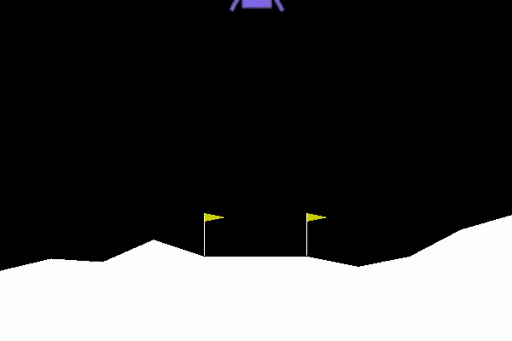
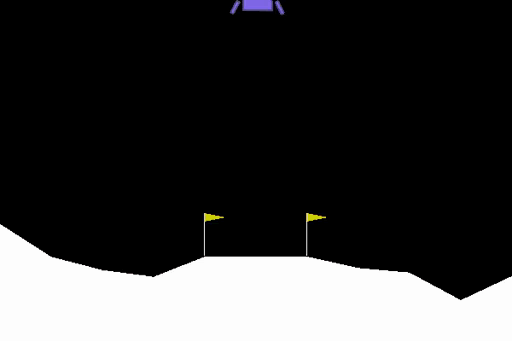
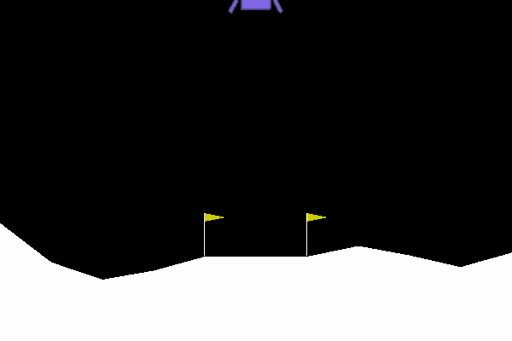
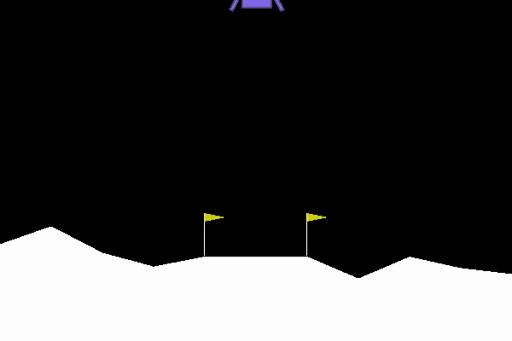

In [60]:
best_agent.demo_progression()


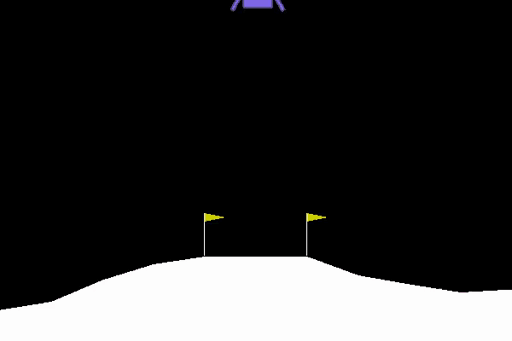
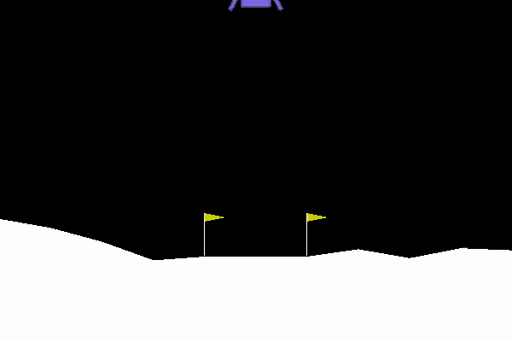

In [66]:
best_agent.demo_last()

In [62]:
ppo_max_t, ppo_max_r, ppo_max_s, \
ppo_max_sec, ppo_max_rt = np.max(ppo_results, axis=0).T
ppo_min_t, ppo_min_r, ppo_min_s, \
ppo_min_sec, ppo_min_rt = np.min(ppo_results, axis=0).T
ppo_mean_t, ppo_mean_r, ppo_mean_s, \
ppo_mean_sec, ppo_mean_rt = np.mean(ppo_results, axis=0).T
ppo_x = np.arange(len(ppo_mean_s))

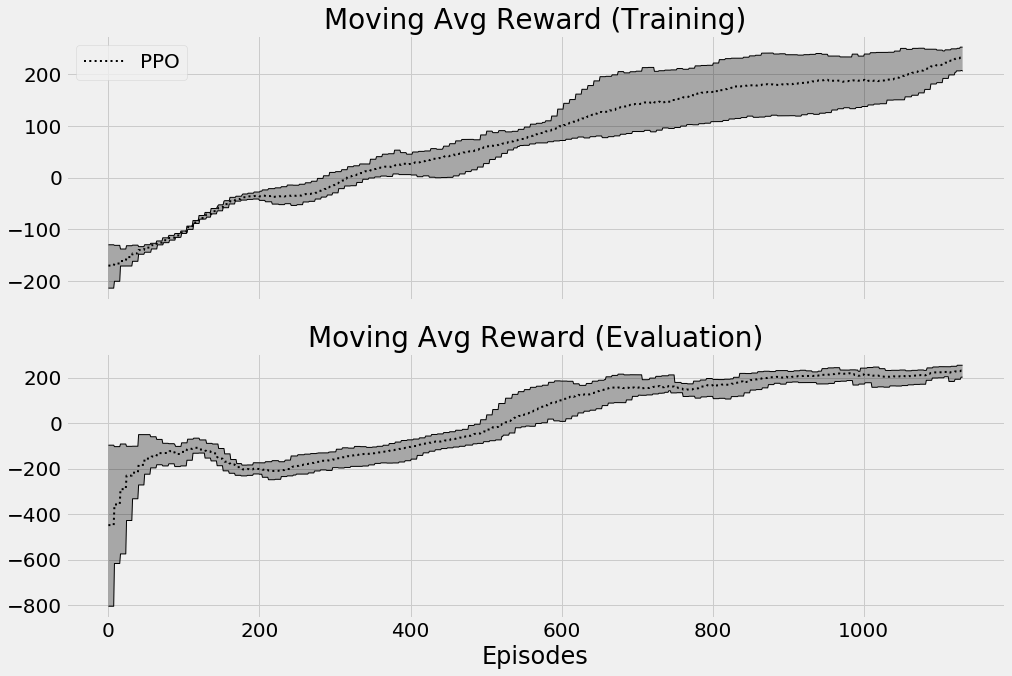

In [63]:
fig, axs = plt.subplots(2, 1, figsize=(15,10), sharey=False, sharex=True)

# PPO
axs[0].plot(ppo_max_r, 'k', linewidth=1)
axs[0].plot(ppo_min_r, 'k', linewidth=1)
axs[0].plot(ppo_mean_r, 'k:', label='PPO', linewidth=2)
axs[0].fill_between(
    ppo_x, ppo_min_r, ppo_max_r, facecolor='k', alpha=0.3)

axs[1].plot(ppo_max_s, 'k', linewidth=1)
axs[1].plot(ppo_min_s, 'k', linewidth=1)
axs[1].plot(ppo_mean_s, 'k:', label='PPO', linewidth=2)
axs[1].fill_between(
    ppo_x, ppo_min_s, ppo_max_s, facecolor='k', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

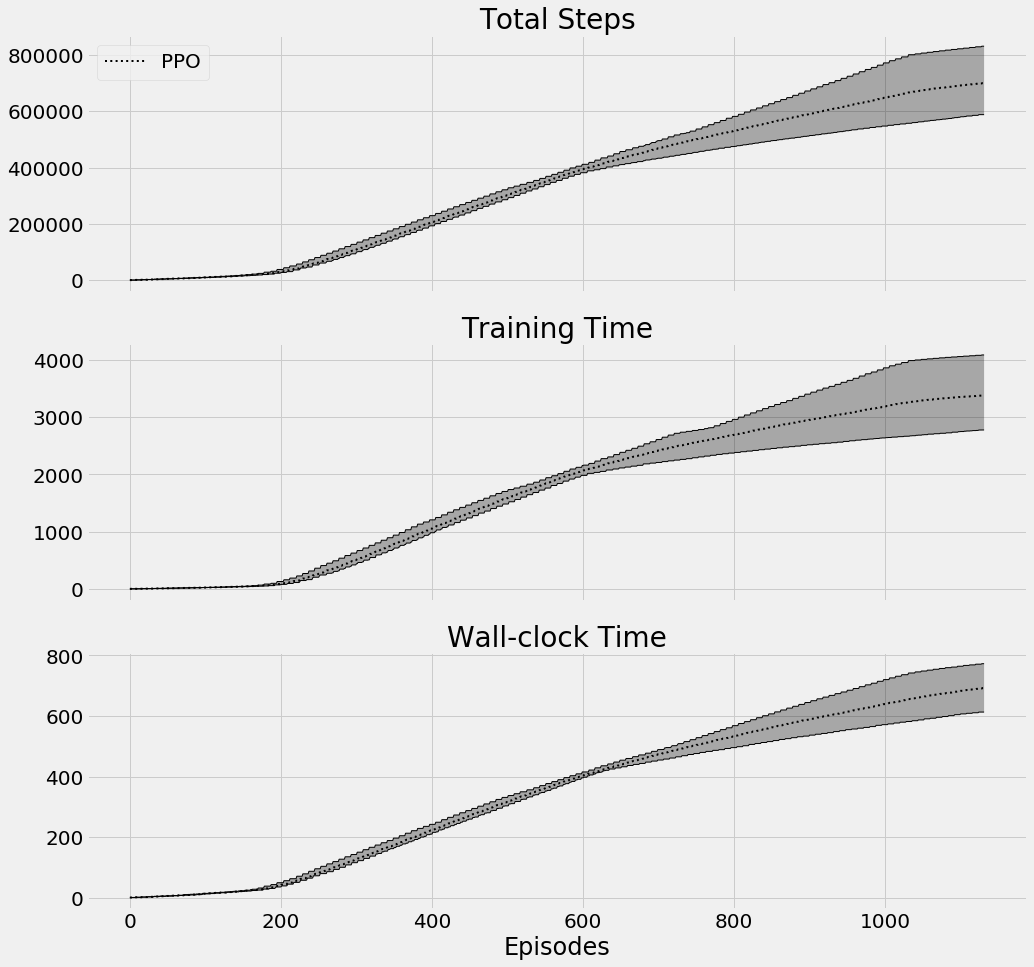

In [64]:
fig, axs = plt.subplots(3, 1, figsize=(15,15), sharey=False, sharex=True)

# PPO
axs[0].plot(ppo_max_t, 'k', linewidth=1)
axs[0].plot(ppo_min_t, 'k', linewidth=1)
axs[0].plot(ppo_mean_t, 'k:', label='PPO', linewidth=2)
axs[0].fill_between(
    ppo_x, ppo_min_t, ppo_max_t, facecolor='k', alpha=0.3)

axs[1].plot(ppo_max_sec, 'k', linewidth=1)
axs[1].plot(ppo_min_sec, 'k', linewidth=1)
axs[1].plot(ppo_mean_sec, 'k:', label='PPO', linewidth=2)
axs[1].fill_between(
    ppo_x, ppo_min_sec, ppo_max_sec, facecolor='k', alpha=0.3)

axs[2].plot(ppo_max_rt, 'k', linewidth=1)
axs[2].plot(ppo_min_rt, 'k', linewidth=1)
axs[2].plot(ppo_mean_rt, 'k:', label='PPO', linewidth=2)
axs[2].fill_between(
    ppo_x, ppo_min_rt, ppo_max_rt, facecolor='k', alpha=0.3)

# ALL
axs[0].set_title('Total Steps')
axs[1].set_title('Training Time')
axs[2].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

In [65]:
ppo_root_dir = os.path.join(RESULTS_DIR, 'ppo')
not os.path.exists(ppo_root_dir) and os.makedirs(ppo_root_dir)

np.save(os.path.join(ppo_root_dir, 'x'), ppo_x)

np.save(os.path.join(ppo_root_dir, 'max_r'), ppo_max_r)
np.save(os.path.join(ppo_root_dir, 'min_r'), ppo_min_r)
np.save(os.path.join(ppo_root_dir, 'mean_r'), ppo_mean_r)

np.save(os.path.join(ppo_root_dir, 'max_s'), ppo_max_s)
np.save(os.path.join(ppo_root_dir, 'min_s'), ppo_min_s )
np.save(os.path.join(ppo_root_dir, 'mean_s'), ppo_mean_s)

np.save(os.path.join(ppo_root_dir, 'max_t'), ppo_max_t)
np.save(os.path.join(ppo_root_dir, 'min_t'), ppo_min_t)
np.save(os.path.join(ppo_root_dir, 'mean_t'), ppo_mean_t)

np.save(os.path.join(ppo_root_dir, 'max_sec'), ppo_max_sec)
np.save(os.path.join(ppo_root_dir, 'min_sec'), ppo_min_sec)
np.save(os.path.join(ppo_root_dir, 'mean_sec'), ppo_mean_sec)

np.save(os.path.join(ppo_root_dir, 'max_rt'), ppo_max_rt)
np.save(os.path.join(ppo_root_dir, 'min_rt'), ppo_min_rt)
np.save(os.path.join(ppo_root_dir, 'mean_rt'), ppo_mean_rt)